# Preamble
Run once

In [2]:
import orca_parser
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy.interpolate import griddata
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

## Functions

In [3]:
#Given a matrix where each row is the xyz coordinates of each atom, calculates the distance between two atoms.
def calcDistance(matrix,i,j):
    '''
    Given a matrix where each row represents the three xyz of an atom, calculates the distance between two atoms.

    Parameters:
    i and j are the row (atom) number 
    '''
    v1 = np.array(matrix[i])
    v2 = np.array(matrix[j])
    d = np.sqrt(np.sum((v1-v2)**2))
    return d

def calcAngle(matrix,i,j,k):
    '''
    Given a matrix where each row represents the three xyz of an atom, calculates the angle between 3 atoms. 
    
    Parameters:
    i and j are the row (atom) number 
    '''
    v1 = np.array(matrix[i])
    v2 = np.array(matrix[j])
    v3 = np.array(matrix[k])
    w1 = v1-v2 
    w2 = v3-v2
    product = np.inner(w1,w2)
    theta = np.arccos(product/(np.linalg.vector_norm(w1)*np.linalg.vector_norm(w2)))*180/np.pi
    return theta

#Returns an array of coordinates and an array of energies (if there are many configurations)
def dataExtractor(filename):
    '''
    Given the path/filename.out
    Returns the coordinates and energies of each atomic configuration, if there are many like in a scan. 
    '''

    output = orca_parser.ORCAParse(filename)
    try:
        print("ORCA exited normally:", output.valid)

    except:
        print("ORCA didn't exit normally")
    #Returns xyz coordinates as arrays. Array i = atom i.
    #If there are many geometries, it returns an array os arrays, each sub-array containing a 3 element array corresponding to xyz coordinates of the i-th atom.
    output.parse_coords()
    #Returns the energies. 
    #If there are many geometries, it returns an array with each geometry.
    output.parse_energies()

    return output.coords, output.energies


def createDataTable(filename):
    '''
    Given the file path/name.out 
    Returns a dataFrame with distances, angle and energies (only for 3 atoms)
    '''

    coords, energies = dataExtractor(filename)
    
    d1 = [calcDistance(m, 0, 1) for m in coords]
    d2 = [calcDistance(m, 1, 2) for m in coords]
    angle = [calcAngle(m,0,1,2) for m in coords]

    #Set the minimum to zero and convert Hartrees to eV
    energies = (np.array(energies) - min(energies))*27.211407953

    data = pd.DataFrame({
        'd1' : d1,
        'd2' : d2, 
        'angle' : angle,
        'energy' : energies
    })

    return data

def make_transparent_colormap(cmap_name, transparent_start=0.7, transparent_power=1.0):
    """
    Create a colormap that becomes transparent at the end
    
    Parameters:
    - cmap_name: name of the base colormap
    - transparent_start: where transparency starts (0-1)
    - transparent_power: controls the fade curve (1=linear, 2=quadratic, etc.)
    """
    base_cmap = plt.get_cmap(cmap_name)
    colors = base_cmap(np.linspace(0, 1, 256))
    
    start_idx = int(len(colors) * transparent_start)
    
    for i in range(start_idx, len(colors)):
        # Calculate transparency with power curve
        progress = (i - start_idx) / (len(colors) - start_idx)
        alpha = 1.0 - progress ** transparent_power
        colors[i, 3] = alpha
    
    return ListedColormap(colors)


def myContourPlot(x,y,z,levels, figName=None, figSize = (8,6),polar = False):
    '''
    Makes a contour plot in either cartesian or polar coordinates
    
    Parameters
    x,y,z: coordinates of the plot
    levels: a np.linspace spanning the visible range of the Z-axis
    figSize: format (a,b)
    polar (optional): if True, makes the plot in polar coordinates 
    '''

    #Create the colormap
    tranparent_hot = make_transparent_colormap('hot', 0.8, 1)

    #Create the grid:
    gridX = np.linspace(min(x), max(x), 100)
    gridY = np.linspace(min(y), max(y), 100)

    X, Y = np.meshgrid(gridX, gridY)
    Z_interp = griddata((x,y),z, (X,Y), method = 'cubic')

    # --- 3. Generate Contour Plot ---
    if not polar:
        fig, ax = plt.subplots(figsize=figSize)
    if polar:
        fig, ax = plt.subplots(figsize=figSize, subplot_kw={'projection':'polar'})

    # Use contourf (filled contour plot)
    contour = ax.contourf(
        X,
        Y,
        Z_interp,
        cmap=tranparent_hot,
        levels=levels,
        extend='max'
    )
    
    # Make figure and axes background transparent
    fig.patch.set_alpha(0.0)
    ax.set_facecolor('none')

    #Make colorbar
    cbar = fig.colorbar(contour)

    plotColor = 'white'

    # Colorbar label and text color
    cbar.set_label('Energías (eV)', fontsize=22, color=plotColor)

    # Make colorbar background transparent
    cbar.ax.set_facecolor('none')

    # Set colorbar tick colors to white
    cbar.ax.tick_params(colors=plotColor)  # This sets both ticks and tick labels to white

    # Optional: Customize colorbar tick label properties
    cbar.ax.tick_params(axis='y', colors=plotColor, labelsize=14)  # Specific to colorbar axis

    # Set spine (axis line) colors to white if you want them visible
    if not polar:
        ax.spines['bottom'].set_color(plotColor)
        ax.spines['top'].set_color(plotColor) 
        ax.spines['right'].set_color(plotColor)
        ax.spines['left'].set_color(plotColor)
    
    if polar:
        ax.patch.set_edgecolor(plotColor)

    ax.set_xlabel('$R_1 (\\AA)$', fontsize=22, color=plotColor)
    ax.set_ylabel('$R_2 (\\AA)$', fontsize=22, color=plotColor)

    # Set tick colors to white
    ax.tick_params(axis='x', colors=plotColor)
    ax.tick_params(axis='y', colors=plotColor)

    # Since the data is discrete, set limits to show the grid clearly
    ax.grid(True, linestyle='--', alpha=0.6, color=plotColor)

    if figName:
        plt.savefig(figName, transparent=True, facecolor='none', edgecolor='none')
    plt.show()

def modeExtractor(modes):
    '''
    Gets a list with displacement corresponding to normal modes [dx1, dy1, dz1, dx2, dy2, dz2, ..., dxi,dyi,dzi]
    Returns an array where each element represents the displacement of one atom: [[dx1,dy1,dz1], [dx2,dy2,dz2], ... [dxi,dyi,dzi]]
    '''
    modesPerAtom = []
    for i in range(1,int((len(modes)+1)/3)+1):
        atomDisplacement = [modes[i*3-3], modes[i*3-2], modes[i*3-1]]
        modesPerAtom.append(atomDisplacement)
    return modesPerAtom

def modeInternalCoordinates(eqPosition, displacement):
    '''
    Given a matrix that contains three atoms, each row cotains the xyz of the atom, transform cartesian to d1,d2,angle, coordinates.
    
    Parameters:
    eqPosition: Matrix with the 3 atoms positions as arrays [x,y,z]
    displacement: Matrix with the 3 atoms displacements corresponding to the normal modes.
    '''
    finalPosition = np.array(eqPosition) + np.array(displacement)/2

    eqd1 = calcDistance(eqPosition, 0, 1)
    eqd2 = calcDistance(eqPosition, 1, 2)
    eqangle = calcAngle(eqPosition, 0, 1, 2)

    finald1 = calcDistance(finalPosition, 0, 1)
    finald2 = calcDistance(finalPosition, 1, 2)
    finalangle = calcAngle(finalPosition, 0, 1, 2)

    internalInitial = np.array([eqd1, eqd2, eqangle])
    internalFinal = np.array([finald1, finald2, finalangle])

    internalDisplacement = internalFinal-internalInitial
    return internalDisplacement

def funcMorse(r, De, re, a):
    ''' 
    Morse potential, the energy minimum is zero.
    '''
    return De*(1-np.exp(-a*(r-re))**2)

def plot_transparent(xlabel='x', ylabel='f(x)', axisColor='white', figsize=(6,4)):
    """
    Plot f(x) on a transparent canvas with white ticks/labels/spines so you can
    paste the PNG onto a black background later.
    - x: array of x values
    - y: array of y values
    - axisColor: color of the axes, ticks, labels (default: white)
    - figsize: figure size (default: (6,4))
    - xlabel, ylabel: axis labels
    Returns (fig, ax)
    """

    fig, ax = plt.subplots(figsize=figsize)
    fig.patch.set_alpha(0.0)        # figure transparent
    ax.set_facecolor('none')        # axes transparent


    # white ticks, labels and spines
    ax.tick_params(colors=axisColor, which='both')
    ax.xaxis.label.set_color(axisColor)
    ax.yaxis.label.set_color(axisColor)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    for spine in ax.spines.values():
        spine.set_color(axisColor)

    return fig, ax

def funcCutter(x0, x, y, z, tolerance = 0):
    '''
    Given an x0, plots y as a function of z. 

    Parameters
    -x0: fixed value of x
    -x: array of x values
    -y: array of y values
    -z: array of values at fixed x0 and variable y
    tolerance: how close can values vary for x0. x0 +- tol

    Returns
    -x_avg: average x value within tolerance
    -y_cut: array of y at x0 +- tolerance
    -z_cut: array of z corresponding to y_cut
    '''
    
    min_x = x0 - tolerance
    max_x = x0 + tolerance 

    x_sum = 0
    count = 0
    y_cut = []
    z_cut = []
    for i in range(len(x)):
        if x[i] >= min_x and x[i] <= max_x:
            count += 1
            x_sum += x[i] 
            y_cut.append(y[i])
            z_cut.append(z[i])
    
    if x_sum == 0:
        print("No data points found within the specified tolerance.")
        return None, None, None
    x_avg = x_sum/count 
    return x_avg, np.array(y_cut), np.array(z_cut)




In [4]:
tranparent_hot = make_transparent_colormap('hot', 0.8, 1)

# H3

ORCA exited normally: True
       d1    d2  angle    energy
0     0.5  0.50  180.0  7.739929
1     0.5  0.55  180.0  6.530273
2     0.5  0.60  180.0  5.629952
3     0.5  0.65  180.0  4.948274
4     0.5  0.70  180.0  4.423484
...   ...   ...    ...       ...
1066  1.5  2.80  180.0  3.067091
1067  1.5  2.85  180.0  3.069076
1068  1.5  2.90  180.0  3.071893
1069  1.5  2.95  180.0  3.073812
1070  1.5  3.00  180.0  3.075417

[1071 rows x 4 columns]


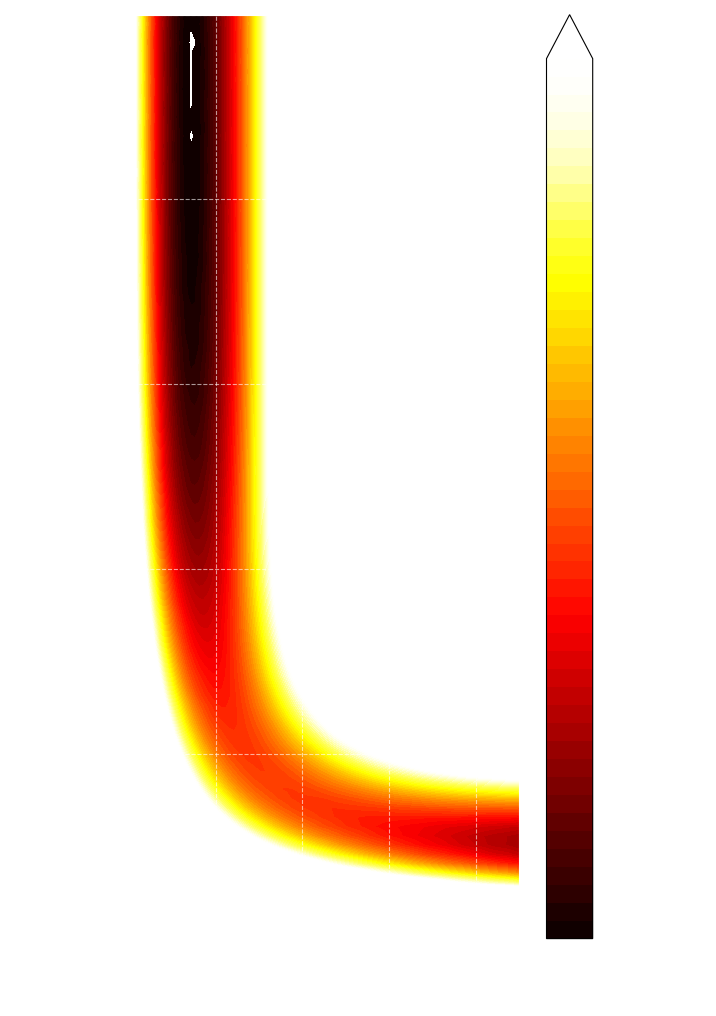

In [5]:
dataH3 = createDataTable('./H3/PES_asoc/PES_H3.out')
print(dataH3)
levels = np.linspace(0,0.4,50)
myContourPlot(dataH3.d1.values, dataH3.d2.values, dataH3.energy.values, levels=levels, figSize=(7,12), figName='H3_PES')


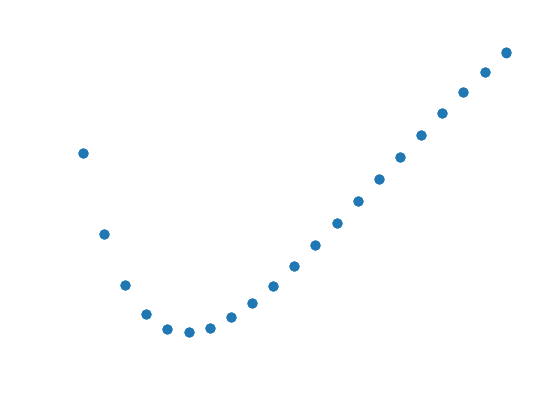

In [6]:
R1_0 = 3.0 
R1_avg, R2, energies_cut = funcCutter(R1_0, dataH3.d2.values, dataH3.d1.values, dataH3.energy.values, tolerance=0.1) 
fig, ax = plot_transparent(xlabel='$R_2 (\\AA)$', ylabel='Energía (eV)', axisColor='white', figsize=(6,4))
ax.set_title(f'Corte a $R_1 = {R1_avg:.2f} \\AA$', color = 'white')
ax.scatter(R2, energies_cut)
plt.show()

ORCA exited normally: True
      d1        d2  angle    energy
0    0.5  0.500000  180.0  7.660820
1    0.5  0.657895  180.0  4.777023
2    0.5  0.815789  180.0  3.518639
3    0.5  0.973684  180.0  2.879194
4    0.5  1.131579  180.0  2.513091
..   ...       ...    ...       ...
395  3.5  2.868421  180.0  4.635982
396  3.5  3.026316  180.0  4.651117
397  3.5  3.184211  180.0  4.661324
398  3.5  3.342105  180.0  4.668435
399  3.5  3.500000  180.0  4.673373

[400 rows x 4 columns]


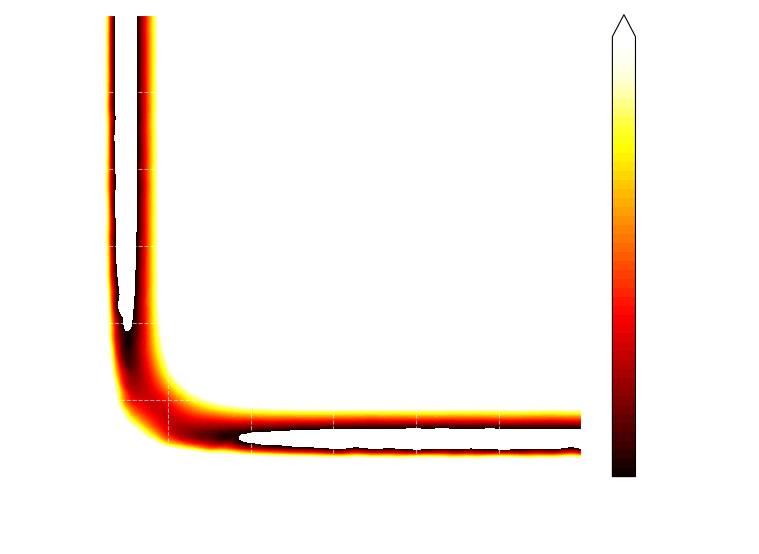

In [7]:
data = createDataTable('./H3/PES/PES_H3.out')
print(data)
levels = np.linspace(0,0.4,50)
myContourPlot(data.d2.values, data.d1.values, data.energy.values, levels=levels, figName='H3_PES')

# O3

### Datos de la optimización de geometría:
$R_1 = 1.250022552503 \AA$ 

$R_2 = 1.250048888393 \AA$

$\theta = 118.35765754°$

ORCA exited normally: True
      d1        d2       angle     energy
0    0.9  0.900000  118.357675  19.613984
1    0.9  1.003448  118.357674  13.118608
2    0.9  1.106897  118.357648   9.956771
3    0.9  1.210344  118.357649   8.478271
4    0.9  1.313794  118.357668   7.854224
..   ...       ...         ...        ...
895  3.9  3.486207  118.357666  14.203479
896  3.9  3.589655  118.357658  14.209438
897  3.9  3.693103  118.357659  14.211026
898  3.9  3.796552  118.357651  14.211075
899  3.9  3.900000  118.357665  14.212900

[900 rows x 4 columns]


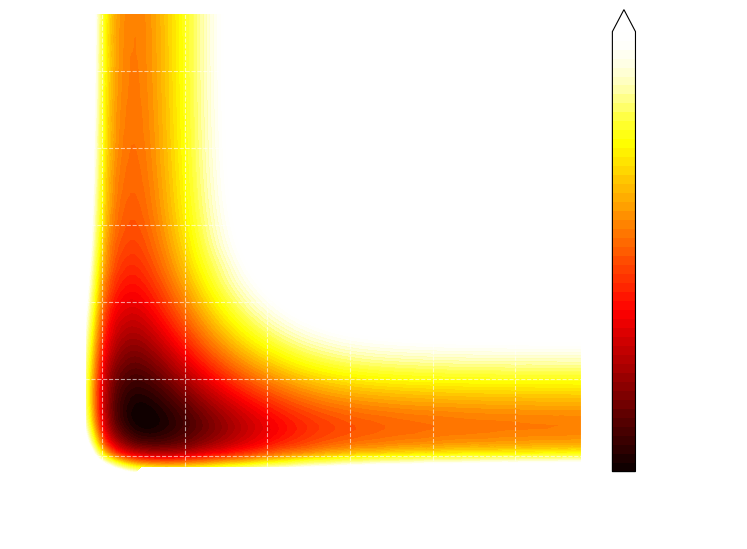

In [8]:
R1_eq = 1.250022552503
R2_eq = 1.250048888393
theta_eq = 118.35765754

dataO3 = createDataTable('./O3/PES_O3/PES_O3.out')
print(dataO3)
levels = np.linspace(-0.1,9,50)
myContourPlot(dataO3.d1.values, dataO3.d2.values, dataO3.energy.values, levels=levels, figName='H3_PES')


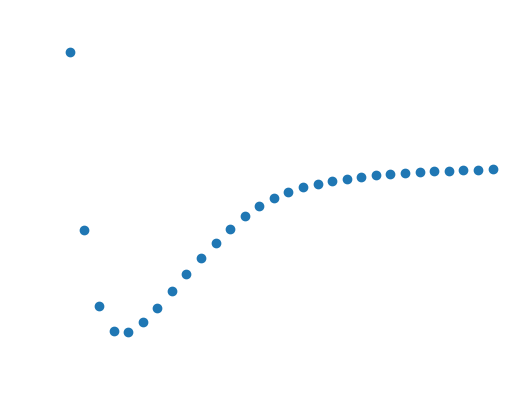

In [9]:
R1_0, R2, O3energies = funcCutter(R1_eq, dataO3.d1.values, dataO3.d2.values, dataO3.energy.values, tolerance=0.05)

fig, ax = plot_transparent(xlabel='$R_2 (\\AA)$', ylabel='Energía (eV)', axisColor='white', figsize=(6,4))
ax.set_title(f'Corte a $R_1 = {R1_eq:.2f} \\AA$', color = 'white')
ax.scatter(R2, O3energies)
plt.show()

In [10]:
O3modes = pd.read_csv('./O3/normalModes.csv', header=None)
O3geom = np.array([
    [0.033284,    0.010140,    0.000000], 
    [1.271290,    0.014479,    0.000000], 
    [1.856350,    1.105554,    0.000000]
    ])

O3mode1_cartesian = modeExtractor(O3modes.iloc[:,0].values)
O3mode2_cartesian = modeExtractor(O3modes.iloc[:,1].values)
O3mode3_cartesian = modeExtractor(O3modes.iloc[:,2].values)

print('La posición de equilibrio está dada por:')
print(O3mode1_cartesian+O3geom)


La posición de equilibrio está dada por:
[[ 0.412411  0.508692  0.      ]
 [ 1.510324 -0.383409  0.      ]
 [ 1.238189  1.00489   0.      ]]


In [11]:
O3mode1_interal = modeInternalCoordinates(O3geom, O3mode1_cartesian)
O3mode2_interal = modeInternalCoordinates(O3geom, O3mode2_cartesian)
O3mode3_interal = modeInternalCoordinates(O3geom, O3mode3_cartesian)

print('Los desplazamientos en distancias y ángulos de los modos normales son:')
print('Bending')
print(O3mode1_interal)
print('Asym Stretch')
print(O3mode2_interal)
print('Sym Stretch')
print(O3mode3_interal)

Los desplazamientos en distancias y ángulos de los modos normales son:
Bending
[ 1.14501756e-02  1.14829425e-02 -4.20179318e+01]
Asym Stretch
[-0.52756899  0.56764742 -9.91605318]
Sym Stretch
[  0.46353517   0.46223816 -22.36256813]


ORCA exited normally: True


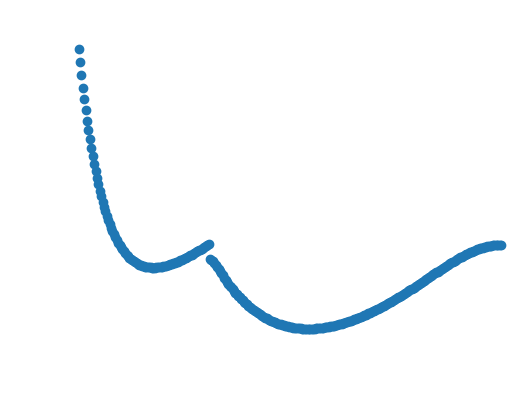

In [12]:
dataO3bendeing = createDataTable('./O3/PES_bending/PES_O3.out')
fig, ax = plot_transparent(xlabel='Ángulo (°)', ylabel='Energía (eV)', axisColor='white', figsize=(6,4))
ax.set_title(f'PES de flexión de O$_3$', color = 'white')
ax.scatter(dataO3bendeing.angle.values, dataO3bendeing.energy.values)
plt.show()

ORCA exited normally: True
[0.9      0.9      0.9      0.9      0.9      0.9      0.9      0.9
 0.9      0.9      0.9      0.9      0.9      0.9      0.9      0.9
 0.9      0.9      0.9      0.9      0.9      0.9      0.9      0.9
 0.9      0.9      0.9      0.9      0.9      0.9      0.9      0.9
 0.9      0.9      0.9      0.9      0.9      0.9      0.9      0.9
 0.9      0.9      0.9      0.9      0.9      0.9      0.9      0.9
 0.9      0.9      1.188889 1.188889 1.188889 1.188889 1.188889 1.188889
 1.188889 1.188889 1.188889 1.188889 1.188889 1.188889 1.188889 1.188889
 1.188889 1.188889 1.188889 1.188889 1.188889 1.188889 1.188889 1.188889
 1.188889 1.188889 1.188889 1.188889 1.188889 1.188889 1.188889 1.188889
 1.188889 1.188889 1.188889 1.188889 1.188889 1.188889 1.188889 1.188889
 1.188889 1.188889 1.188889 1.188889 1.188889 1.188889 1.188889 1.188889
 1.188889 1.188889 1.188889 1.188889 1.477778 1.477778 1.477778 1.477778
 1.477778 1.477778 1.477778 1.477778 1.477778 1.477778

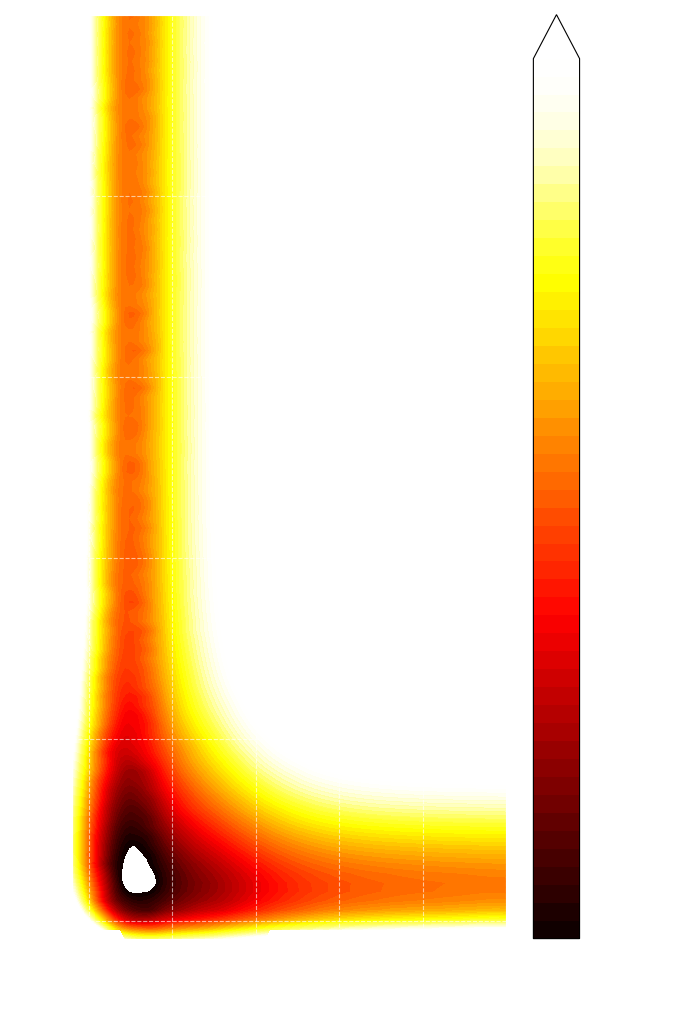

In [13]:
dataO3_disoc = createDataTable('./O3/PES_disoc/PES_O3.out')
print(dataO3_disoc.d1.values)
levels = np.linspace(-0.1,9,50)
myContourPlot(dataO3_disoc.d1.values, dataO3_disoc.d2.values, dataO3_disoc.energy.values, levels=levels, figSize=(7,12),figName='O3_disoc_PES')


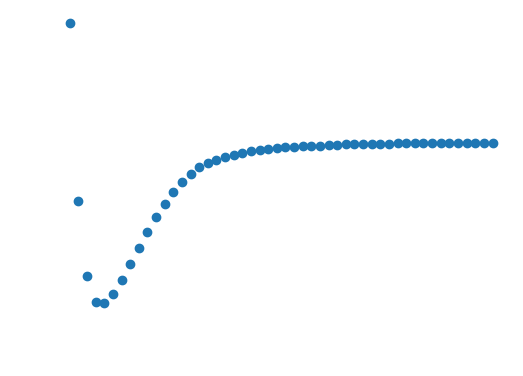

In [14]:
R1_cut = 1.2
tol = 0.12
R1_O3_disoc_0, R2_O3_disoc, O3_disoc_energies = funcCutter(R1_cut, dataO3_disoc.d1.values, dataO3_disoc.d2.values, dataO3_disoc.energy.values, tolerance=tol)
fig, ax = plot_transparent(xlabel='$R_2 (\\AA)$', ylabel='Energía (eV)', axisColor='white', figsize=(6,4))
ax.scatter(R2_O3_disoc, O3_disoc_energies)
#ax.set_ylim(13.67,13.72)
plt.show()

# OCN

Equilibrium Position

 O      0   0   0     0.000000000000     0.00000000     0.00000000

 C      1   0   0     1.171860545810     0.00000000     0.00000000
 
 N      2   1   0     1.224112031712   179.99995889     0.00000000

ORCA exited normally: True


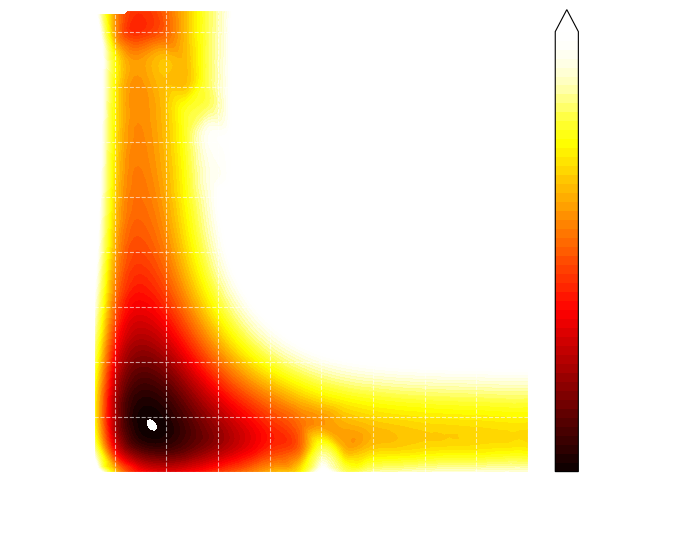

In [15]:
dataOCN_disoc = createDataTable('./OCN/OCN_disocTest/OCN_disoc.out')
myContourPlot(dataOCN_disoc.d1.values, dataOCN_disoc.d2.values, dataOCN_disoc.energy.values, levels=np.linspace(-0.1,9,50), figSize=(7,6))
#R1 = d_O-C
#R2 = d_C-N

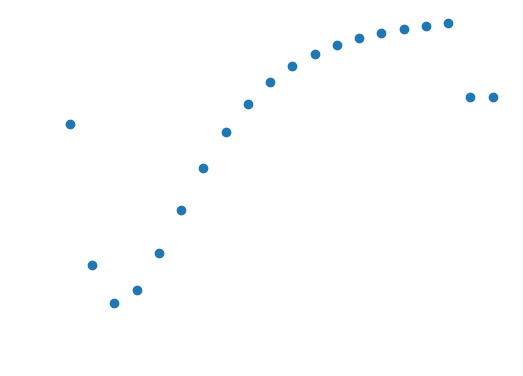

In [16]:
OCN_dOC_eq = 1.17
tol = 0.06
OCN_dOC_0, OCN_dCN, OCN_CN_energies  = funcCutter(OCN_dOC_eq, dataOCN_disoc.d1.values, dataOCN_disoc.d2.values, dataOCN_disoc.energy.values, tolerance=tol)
fig, ax = plot_transparent(xlabel='$d_{C-N} (\\AA)$', ylabel='Energía (eV)', axisColor='white', figsize=(6,4))
ax.scatter(OCN_dCN, OCN_CN_energies)
plt.show()

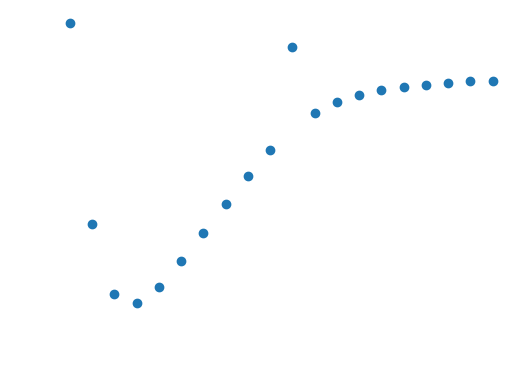

In [17]:
OCN_dCN_eq = 1.12
tol = 0.05
OCN_dCN_0, OCN_dCN, OCN_CN_energies  = funcCutter(OCN_dCN_eq, dataOCN_disoc.d2.values, dataOCN_disoc.d1.values, dataOCN_disoc.energy.values, tolerance=tol)
fig, ax = plot_transparent(xlabel='$d_{O-C} (\\AA)$', ylabel='Energía (eV)', axisColor='white', figsize=(6,4))
ax.scatter(OCN_dCN, OCN_CN_energies)
plt.show()    

# CNO 

ORCA exited normally: True
       d1    d2  angle    energy
0   1.062  1.05  180.0  1.645663
1   1.062  1.10  180.0  0.715670
2   1.062  1.15  180.0  0.204503
3   1.062  1.20  180.0  0.000000
4   1.062  1.25  180.0  0.016194
5   1.062  1.30  180.0  0.187579
6   1.062  1.35  180.0  0.463800
7   1.062  1.40  180.0  0.806204
8   1.062  1.45  180.0  1.185620
9   1.062  1.50  180.0  1.578156
10  1.062  1.55  180.0  1.958481
11  1.062  1.60  180.0  2.296763
12  1.062  1.65  180.0  2.579502
13  1.062  1.70  180.0  2.816409
14  1.062  1.75  180.0  3.005155
15  1.062  1.80  180.0  3.155321
16  1.062  1.85  180.0  3.273211
17  1.062  1.90  180.0  3.364941
18  1.062  1.95  180.0  3.436482
19  1.062  2.00  180.0  3.493015
20  1.062  2.05  180.0  3.536395
21  1.062  2.10  180.0  3.570669
22  1.062  2.15  180.0  3.597881
23  1.062  2.20  180.0  3.619902
24  1.062  2.25  180.0  3.638252
25  1.062  2.30  180.0  3.653681
26  1.062  2.35  180.0  3.666870
27  1.062  2.40  180.0  3.678378
28  1.062  2.45 

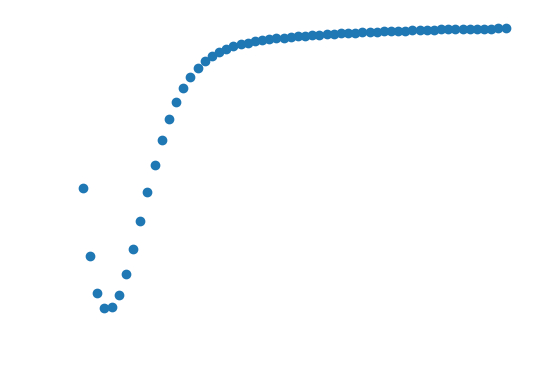

In [ ]:
CNO_data = createDataTable('./CNO/CNO_C-NO_disocTest/CNO_disoc.out')
print(CNO_data)
fig, ax = plot_transparent(xlabel='$d_{N-O} (\\AA)$', ylabel='Energía (eV)', axisColor='white', figsize=(6,4))
ax.scatter(CNO_data.d2.values, CNO_data.energy.values)
#ax.set_ylim(3.6,3.85)
plt.show()

ORCA exited normally: True
         d1        d2  angle     energy
0    0.9988  1.011400  180.0   5.496314
1    0.9988  1.115092  180.0   3.173848
2    0.9988  1.218783  180.0   2.545476
3    0.9988  1.322475  180.0   2.782352
4    0.9988  1.426167  180.0   3.406020
..      ...       ...    ...        ...
620  3.5000  3.085233  180.0  11.171132
621  3.5000  3.188925  180.0  11.184593
622  3.5000  3.292617  180.0  11.195430
623  3.5000  3.396308  180.0  11.203641
624  3.5000  3.500000  180.0  11.209866

[625 rows x 4 columns]


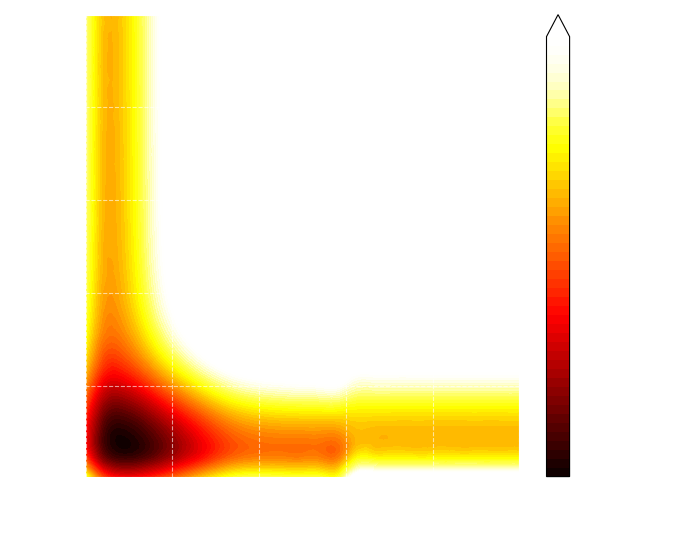

In [34]:
dataCNO_disoc = createDataTable('./CNO/CNO_disoc/CNO_disoc.out')
print(dataCNO_disoc)
levels = np.linspace(-0.1,7,50)
myContourPlot(dataCNO_disoc.d1.values, dataCNO_disoc.d2.values, dataCNO_disoc.energy.values, levels=levels, figSize=(7,6))


In [ ]:
R2CNO_eq = 1.3
R2_CNO_av,  = funcCutter(R2_eq, dataCNO_disoc.d2.values, dataCNO_disoc.d1.values, dataCNO_disoc.energy.values, tolerance=0.05)
fig, ax = plot_transparent(xlabel='$d_{N-O} (\\AA)$', ylabel='Energía (eV)', axisColor='white', figsize=(6,4))
